# Representing an Artificial Neural Network as a Cartesian Genetic Program
(a.k.a dCGPANN)

Neural networks (deep, shallow, convolutional or not) are, after all, computer programs and as such can be encoded in a chromosome and represented as a Genetic Program. A dCGPANN, coded in the class *expression_ann_double*, is exactly this: a feed forward neural network represented into a chromosome using a Cartesian Genetic Programming encoding. Derivatives with respect to weights and biases can be easily extracted, the underlying algorithm being backward automated differentiation. Unlike other dCGP expression higher order derivatives are not available (no *gduals*). 

In [1]:
# Initial import
import dcgpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline

### Data set

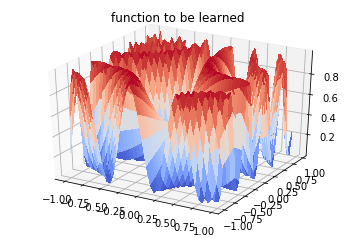

In [2]:
# To plot the unction we use a uniform grid
X = np.arange(-1, 1, 0.05)
Y = np.arange(-1, 1, 0.05)
n_samples = len(X) * len(Y)
points = np.zeros((n_samples, 2))

i=0
for x in X:
    for y in Y:
        points[i][0] = x
        points[i][1] = y
        i=i+1
labels = (np.sin(5 * points[:,0] * (3 * points[:,1] + 1.)) + 1. ) / 2.
points = points.reshape((n_samples,2))
labels = labels.reshape((n_samples,1))

# To plot the function 
X, Y = np.meshgrid(X, Y)
Z = (np.sin(5 * X * (3 * Y + 1.)) + 1. ) / 2.
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# We shuffle the points and labels
points, labels = shuffle(points, labels, random_state=0)
# We creat training and test sets
X_train = points[:800]
Y_train = labels[:800]
X_test = points[800:]
Y_test = labels[800:]
_ = plt.title("function to be learned")

### Mutating a dCGPANN

In [3]:
# Non linearities
nonlinearities = dcgpy.kernel_set_double(["sig"])
arity = 24
# We define a single input single output dCGPANN.
dcgpann = dcgpy.expression_ann_double(inputs=2, outputs=1, rows=30, cols=3, 
                                      levels_back=1, arity=arity, kernels=nonlinearities())
# By default all weights (and biases) are set to 1 (and 0). We initialize them randomly
dcgpann.randomise_weights(mean = 0., std = 3.)
#dcgpann.randomise_biases(mean = 0., std = 2.)

# Since the output is in [-1, 1] we force the output nonliearity to be tanh
dcgpann.set_output_f(0)

print("Starting error:", dcgpann.loss(points,labels, "MSE"))
print("Net complexity (number of active weights):", (len(dcgpann.get_active_nodes())-2) * arity)
x = dcgpann.get()
w = dcgpann.get_weights()
b = dcgpann.get_biases()
res = []

Starting error: 0.3686774936123335
Net complexity (number of active weights): 1176


100%|██████████| 1000/1000 [00:04<00:00, 225.90it/s]


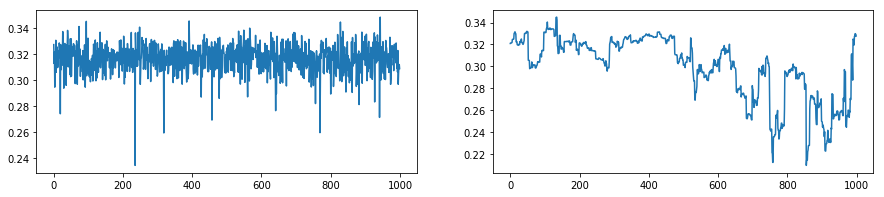

In [4]:
# We show the effect of mutations
n_mutations = 1000
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(x)
    dcgpann.set_weights(w)
    dcgpann.set_biases(b)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))
    
mut2 = []
dcgpann.set(x)
dcgpann.set_weights(w)
dcgpann.set_biases(b)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(1)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(X_train,Y_train, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


In [5]:
lr0 = 0.3
for i in tqdm(range(5000)):
    lr = lr0 * np.exp(-0.0001 * i)
    dcgpann.sgd(X_train, Y_train, lr, 800, "MSE")
    res.append(dcgpann.loss(X_train,Y_train, "MSE"))

100%|██████████| 5000/5000 [01:04<00:00, 77.48it/s]


In [14]:
lr

0.1819773947434077

RMSE:  0.3115751988112906
MSE:  0.09707910451429524


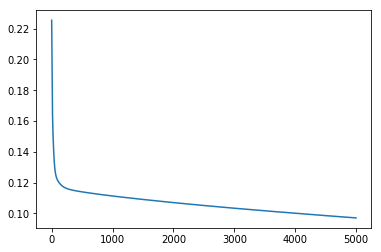

In [15]:
plt.plot(res)
print("RMSE: ", np.sqrt(res[-1]))
print("MSE: ", res[-1])

In [55]:
# We train
n_epochs = 200
print("Start error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

for i in tqdm(range(n_epochs)):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

print("Current error:", dcgpann.loss(X_train,Y_train, "MSE"), flush=True)

xt = dcgpann.get()
wt = dcgpann.get_weights()
bt = dcgpann.get_biases()


Start error: 0.014234695846606058


100%|██████████| 200/200 [00:02<00:00, 97.26it/s] 

Current error: 0.013925553681014552


100%|██████████| 1000/1000 [00:05<00:00, 191.75it/s]


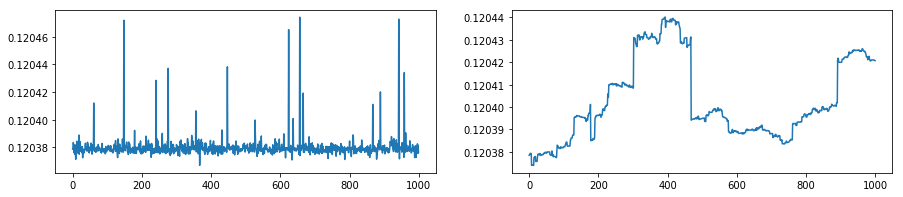

In [58]:
# We show the effect of mutations
n_mutations = 1000
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    mut.append(dcgpann.loss(points,labels, "MSE"))
    
mut2 = []
dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in tqdm(range(n_mutations)):
    dcgpann.mutate_active_cgene(1)
    dcgpann.set_output_f(0)
    mut2.append(dcgpann.loss(points,labels, "MSE"))

#plot
f, ax = plt.subplots(1,2, figsize=(15,3))
plt.subplot(1,2,1)
_ = plt.plot(mut)
plt.subplot(1,2,2)
_ = plt.plot(mut2)


100%|██████████| 10/10 [01:22<00:00,  8.24s/it]


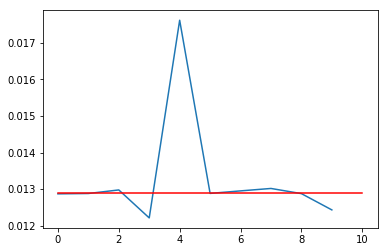

In [56]:
# We show the effect of trained mutations
n_mutations = 10
mut = []
for i in tqdm(range(n_mutations)):
    dcgpann.set(xt)
    dcgpann.set_weights(wt)
    dcgpann.set_biases(bt)
    dcgpann.mutate_active_cgene(10)
    dcgpann.set_output_f(0)
    for i in range(1000):
        dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")
    mut.append(dcgpann.loss(X_train,Y_train, "MSE"))

dcgpann.set(xt)
dcgpann.set_weights(wt)
dcgpann.set_biases(bt)
for i in range(1000):
    dcgpann.sgd(X_train, Y_train, 0.3, 32, "MSE")

_ = plt.plot(mut)
_ = plt.plot([0,n_mutations],[dcgpann.loss(X_train,Y_train, "MSE"),dcgpann.loss(X_train,Y_train, "MSE")],'r')

In [122]:
mut

[0.0030318785355370106,
 0.027238480360689432,
 0.00269167459954895,
 0.008167443610610354,
 0.0026610909231819064,
 0.002682994016606878,
 0.002650835191040724,
 0.0026505487886892896,
 0.0032634602484503277,
 0.0026628230305549483]

In [123]:
dcgpann.loss(points,labels, "MSE")

0.002628766527613083

(array([ 30., 157., 413., 679., 740., 473., 172.,  30.,   4.,   2.]),
 array([-5.92727479, -4.4606454 , -2.99401602, -1.52738663, -0.06075725,
         1.40587214,  2.87250152,  4.3391309 ,  5.80576029,  7.27238967,
         8.73901906]),
 <a list of 10 Patch objects>)

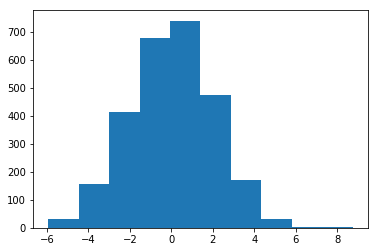

In [63]:
w = dcgpann.get_weights()
plt.hist(w)

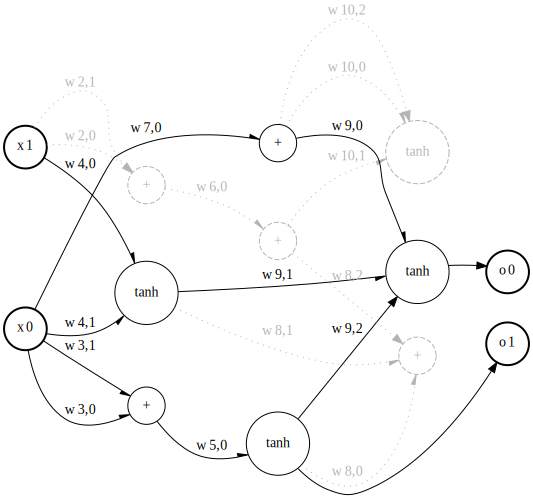

In [3]:
# Initial import
import dcgpy
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle

%matplotlib inline
nonlinearities = dcgpy.kernel_set_double(["sum", "tanh"])

ex  = dcgpy.expression_weighted_double(2,2,3,3,2,[2,1,3],nonlinearities())
ex.visualize(draw_weights=True)

In [14]:
ex.get()

[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [13]:
from graphviz import Digraph

In [28]:
dot = Digraph(comment='The Round Table')

In [29]:
>>> dot.node('A', 'A')
>>> dot.node('B', 'B')
>>> dot.node('L', 'L')

>>> dot.edges(['AB', 'AL'])
>>> dot.edge('B', 'L', constraint='false')

In [30]:
dot.render()

'Digraph.gv.pdf'

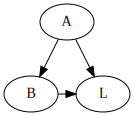

In [31]:
dot


In [ ]:
dot.edge()